<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/verified/CBF/Buck_robust_Voltage_regulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buck converter

In the we present the model of a buck dc-dc converter in OpenAI gym environment.

In [1]:
import numpy as np
import gym
from gym import spaces

import matplotlib.pyplot as plt

#Physical Model
The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+V-uV_s\\
C\dot{V} &= I-GV
\end{align}


> ![alt text](https://i.imgur.com/AdJlqEN.png)







The parameters are:


*   L - Inductance
*   C - Capacitance
*   R - Series Resistance
*   G - Load Impedance
*   $V_s$ - Source Voltage

The state variables:
*  $I\geq 0$ - current through the inductor
*  $V\geq 0$ - voltage across the Capacitor

Input:
* $u\in (0,1)$ - duty-ratio

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - (V-V_d)^2 
\end{align}




In [2]:
#@title ##Parameters

#@markdown ---

#@markdown ###System Parameters (Units in 1e-3).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 38.8 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 380 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 280 #@param {type:"slider", min: 100, max:500, step:10}


C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3


# Gym Model

# New Section

In [43]:
class Buck_Converter_n(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5):
        super(Buck_Converter_n, self).__init__()

        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        self.Ides = self.G * self.Vdes
        self.udes = (1/self.Vs) * (1 + self.G * self.R) * self.Vdes
        if self.Vs <= self.Vdes:
            raise ValueError("for buck converter desired voltage should be less the source Voltage")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float32)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides  , high = self.Ides )
        V = np.random.uniform(low = self.Vdes-1, high = self.Vdes-1)
        self.state = np.array([I, V])

    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):

        u = np.clip(action, 0, 1)

        i = self.state[0]
        v = self.state[1]

        didt = (-1.0/self.L)*(self.R*i + v - self.Vs*u)
        dvdt = (1.0/self.C)*(i - self.G*v)

        new_i = i + self.T * didt
        
        new_v = v + self.T * dvdt


        self.state = np.array([new_i, new_v]).astype(np.float32)

        # normalize the rewards
        reward = -((new_v-self.Vdes))**2
        done = False
        return self.state, reward, done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))

    def close(self):
        pass

# Testing

In [54]:
def plot_signals(data, Ides, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(des[i]-10, des[i]+10)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

def plot_signals(data, Ides, Vdes, dt = 1e-5, dv = 1):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i] - dv), marker = '.')
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i] + dv), marker = '.')
        ax[i].set_ylim(des[i]-10, des[i]+10)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()    

## Constant input policy

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 199.9919618347168
differentials 0.04138183592772293 0.3216552734377487
differentials 8.00000041381836 

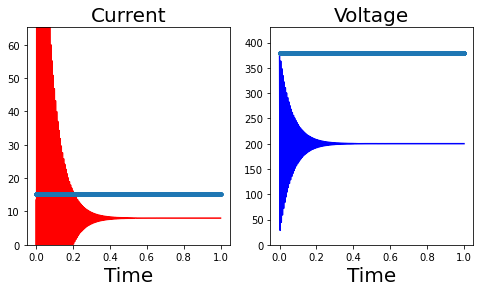

In [66]:
env = Buck_Converter_n()

env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(0.5)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

## Stabilizing  input policy

In [ ]:
env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

#CBF

##Method - 1

A general Quardratic program

\begin{equation}
\hspace{0.25cm} 
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{argmin}}   ~~~~(1/2)x^\top Px + Qx + r&&\\
& \text{subject to} & &\\
&   G x \geq h & &\\
&  Ax = b & &\\
\end{aligned}
\end{equation} 

Let $\Delta$ denote the step size. $\eta_1,~\eta_2 \in [0,1]$. We have the following constraints

\begin{equation}
K(I_t,V_t, \underline V) + \Delta^2 (LC)^{-1}V_s u_t  \geq 0\\
-K(I_t,V_t, \overline V) - \Delta^2 (LC)^{-1}V_s u_t \geq 0
\end{equation}
where 
\begin{align}
K(I_t,V_t, *) &= (\beta + \eta_2) \Delta C^{-1}I_t - (\beta \Delta C^{-1}G +\Delta^2 (LC)^{-1}-\eta_2\beta) V_t-\eta \eta_2 *\\
&=c_1I_t = c_2V_t -\eta \eta_2 *
\end{align}
and 
$\beta = (\eta_1 - \Delta C^{-1}G) $, $c_1 = (\beta+\eta_2)\Delta C^{-1}$ and $c_2 = (\beta \Delta C^{-1}G +\Delta^2 (LC)^{-1}-\eta_2\beta)$. 

In Case the contraints are not feasible, we let them violate minimally

\begin{equation}
K(I_t,V_t, \underline V) + \Delta^2 (LC)^{-1}V_s u_t + \epsilon_1 \geq 0\\
-K(I_t,V_t, \overline V) - \Delta^2 (LC)^{-1}V_s u_t +\epsilon_2 \geq 0
\end{equation}
where $\epsilon_1, ~ \epsilon_2 \in \mathbb{R}^{m+1}$ and $\|\epsilon_1\|_2^2 + ~ \|\epsilon_2\|_2^2$ is used in the cost function.
Moreover we have $u \in (0,~1)$ i.e.,
\begin{align}
u  \geq& 0\\
-u\geq& -1
\end{align}

\begin{equation}
\hspace{0.25cm} 
\begin{aligned}
& \underset{u, \epsilon \in \mathbb{R}^n}{\text{argmin}}   ~~~~(1/2)\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}^\top \underbrace{\begin{bmatrix} 1&0&0\\0& 10^{24}&0\\0&0&10^{24} \end{bmatrix}}_P\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix} &&\\
& \text{subject to} & &\\
&   \underbrace{\begin{bmatrix} 
\Delta^2 (LC)^{-1}&1 &0\\
-\Delta^2 (LC)^{-1}& 0&1 \\
1 &0 &0\\
-1 & 0&0
\end{bmatrix}}_{G}
\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}
\geq
\underbrace{
    \begin{bmatrix}
    -K(I_t,V_t, \underline V)\\
    K(I_t,V_t, \overline V)\\
    0\\
    -1
    \end{bmatrix}}_{h} & &
\end{aligned}
\end{equation} 

In [77]:
eta_1 = 0.5
eta_2 = 0.6
#Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5

def K_cbf_l(env, eta_1, eta_2, V_l):
    i = env.state[0]
    v = env.state[1]

    
    delta = env.T
    inv_C = 1/env.C 
    L = env.L 
    G = env.G 
    inv_LC = 1/(env.L*env.C)
    beta = eta_1 - delta*(inv_C)*G
    c1 = (beta + eta_2) * delta * inv_C
    c2 = (beta * delta * inv_C * G + (delta**2)*inv_LC - eta_2*beta)

    temp = c1 * i - c2 * v - eta_1*eta_2* V_l
    #print(temp)
    return temp

def K_cbf_h(env, eta_1, eta_2, V_h):
    i = env.state[0]
    v = env.state[1]

    delta = 1#env.T
    inv_C = 1/env.C 
    L = env.L 
    G = env.G 
    inv_LC = 1/(env.L*env.C)
    beta = eta_1 - delta*(inv_C)*G
    c1 = (beta + eta_2) * delta * inv_C
    c2 = (beta * delta * inv_C * G + (delta**2)*inv_LC - eta_2*beta)

    temp = -c1 * i + c2 * v + eta_1*eta_2* V_h
    #print(temp)
    return temp



In [88]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on Thu Aug 16 14:17:49 2018

# @author: rcheng
# """

# import numpy as np
# from cvxopt import matrix
# from cvxopt import solvers

# #Build barrier function model
# def cbf(env):
#     eta_1 = 0.5 
#     eta_2 = 0.5
#     V_l  = env.Vdes - 2
#     V_h = env.Vdes +2
#     N = 1
#     P = matrix(np.diag([1., 1e24, 1e24]), tc='d')
#     q = matrix(np.zeros(3))
#     delta = env.T
#     c = (delta**2)*(1/(env.L*env.C))
#     print(c)

#     G = -np.array([[c, 1, 0], [-c, 0, 1], [1, 0, 0], [-1, 0, 0]])
#     G = matrix(G,tc='d')

#     h = -np.array([-K_cbf_l(env, eta_1, eta_2, V_l), K_cbf_h(env, eta_1, eta_2, V_h), 0, -1])
#     print(h)
#     h = np.squeeze(h).astype(np.double)
#     h = matrix(h,tc='d')

#     solvers.options['show_progress'] = False
#     sol = solvers.qp(P, q, G, h)

#     u_bar = sol['x']
#     if np.abs(u_bar[1]) > 0.001:
#         print("Violation of Safety: ")
#         print(u_bar[1])
#     return u_bar[0]






##Method-2

\begin{align*}
    H_1&= uV_s - V +\eta_a (I - G \underline V) \geq 0\\
    H_2&=-uV_s + V  +  \eta_b (G \overline{V} - I) \geq 0
\end{align*}

\begin{equation}
\hspace{0.25cm} 
\begin{aligned}
& \underset{u, \epsilon \in \mathbb{R}^n}{\text{argmin}}   ~~~~(1/2)\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}^\top \underbrace{\begin{bmatrix} 0&0&0\\0& 10^{24}&0\\0&0&10^{24} \end{bmatrix}}_P\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix} &&\\
& \text{subject to} & &\\
&   \underbrace{-\begin{bmatrix} 
V_s&1 &0\\
-V_s& 0&1 \\
1 &0 &0\\
-1 & 0&0
\end{bmatrix}}_{G}
\begin{bmatrix}
u\\
\epsilon_1\\
\epsilon_2
\end{bmatrix}
\leq
\underbrace{-
    \begin{bmatrix}
    V - \eta_a (I - G \bar V)\\
    -V + \eta_a (I - G \underline V)\\
    0\\
    -1
    \end{bmatrix}}_{h} & &
\end{aligned}
\end{equation} 

In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 16 14:17:49 2018

@author: rcheng
"""

import numpy as np
from cvxopt import matrix
from cvxopt import solvers

#Build barrier function model
def cbf_2(env, eta_1 = 0.5, eta_2 = 0.5, dV = 5, G_diss = 0.02):
    eta_1 = 0.5 
    eta_2 = 0.5
    V_l  = env.Vdes - dV
    V_h = env.Vdes + dV
    N = 1
    P = matrix(np.diag([0.0, 1e24, 1e24]), tc='d')
    q = matrix(np.zeros(3))
    delta = env.T

    I = env.state[0]
    V = env.state[1]

    c_h = V - eta_1 * (I - (env.G-G_diss) * V_l)
    c_l = - V + eta_2 * (I - (env.G+G_diss) * V_h)
    #print(c)

    G = -np.array([[env.Vs, 1, 0], [-env.Vs, 0, 1], [1, 0, 0], [-1, 0, 0]])
    G = matrix(G,tc='d')

    h = -np.array([c_h, c_l, 0, -1])
    #print(h)
    h = np.squeeze(h).astype(np.double)
    h = matrix(h,tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h)

    u_bar = sol['x']
    if np.abs(u_bar[1]) > 0.001:
        print("Violation of Safety: ")
        print(u_bar[1])
    return u_bar[0]






/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ 15.2 379. ]
input: 0.9476222023612351
step:  0
step:  1000
step:  2000
step:  3000
step:  4000
step:  5000
step:  6000
step:  7000
step:  8000
step:  9000


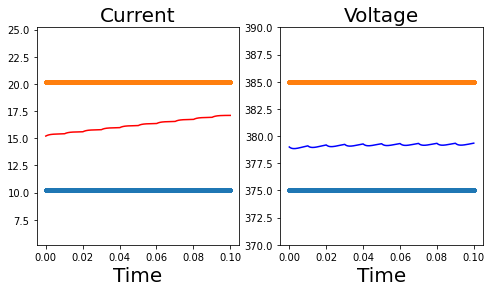

In [63]:
env = Buck_Converter_n()

env.reset()
print(env.state)
obs = []
N_steps = 10**4
G_diss = 0.0005
print('input: {}'.format(cbf_2(env, eta_1 = 100, eta_2 = 100, dV =  5)))
for i in range(N_steps):
    if i%1000 == 0:
        env.G = env.G+G_diss
        print('step: ', i)
    #print('input: {}'.format(cbf_2(env)))
    s, r, _, _ = env.step(cbf_2(env, eta_1 = 100000, eta_2 = 10000, dV =  2))
    obs.append(s)

trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5, dv = 5)

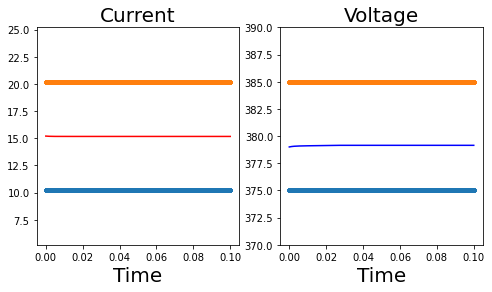

In [58]:
trajectory = np.concatenate(obs).reshape((10**4  ,env.observation_space.shape[0]))

plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5, dv = 5)

In [ ]:
eta_1 = 0.5
eta_2 = 0.6
Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5

def K_cbf_l(env, eta_1, eta_2, V_l):
    i = env.state[0]
    v = env.state[1]

    
    delta = env.dt
    inv_C = 1/env.C 
    L = env.L 
    G = env.G 
    inv_LC = 1/(env.L*env.C)
    beta = eta_1 - delta*(inv_C)*G
    c1 = (beta + eta_2) * delta * inv_C
    c2 = (beta * delta * inv_C * G + (delta**2)*inv_LC - eta_2*beta)

    temp = c1 * i - c2 * v - eta_1*eta_2* V_l
    return temp

def K_cbf_h(env, eta_1, eta_2, V_h):
    i = env.state[0]
    v = env.state[1]

    delta = env.dt
    inv_C = 1/env.C 
    L = env.L 
    G = env.G 
    inv_LC = 1/(env.L*env.C)
    beta = eta_1 - delta*(inv_C)*G
    c1 = (beta + eta_2) * delta * inv_C
    c2 = (beta * delta * inv_C * G + (delta**2)*inv_LC - eta_2*beta)

    temp = -c1 * i + c2 * v + eta_1*eta_2* V_h
    return temp
    

# #Get compensatory action based on satisfaction of barrier function
# def control_barrier(self, obs, u_rl, f, g, x, std):
#     #Define gamma for the barrier function
#     gamma_b = 0.5
    
#     #Set up Quadratic Program to satisfy the Control Barrier Function
#     kd = 1.5
#     u_a = 0
    
#     G = np.array([[-np.dot(self.H1,g), -np.dot(self.H2,g), -np.dot(self.H3,g), -np.dot(self.H4,g), 1, -1, g[1], -g[1]], [-1, -1, -1, -1, 0, 0, 0, 0]])
#     G = np.transpose(G)

#     h = np.array([gamma_b*self.F + np.dot(self.H1,f) + np.dot(self.H1,g)*u_a - (1-gamma_b)*np.dot(self.H1,x) - kd*np.dot(np.abs(self.H1),std),
#                   gamma_b*self.F + np.dot(self.H2,f) + np.dot(self.H2,g)*u_a - (1-gamma_b)*np.dot(self.H2,x) - kd*np.dot(np.abs(self.H2),std),
#                   gamma_b*self.F + np.dot(self.H3,f) + np.dot(self.H3,g)*u_a - (1-gamma_b)*np.dot(self.H3,x) - kd*np.dot(np.abs(self.H3),std),
#                   gamma_b*self.F + np.dot(self.H4,f) + np.dot(self.H4,g)*u_a - (1-gamma_b)*np.dot(self.H4,x) - kd*np.dot(np.abs(self.H4),std),
#                   -u_rl + self.torque_bound,
#                   u_rl + self.torque_bound,
#                   -f[1] - g[1]*u_rl + self.max_speed,
#                   f[1] + g[1]*u_rl + self.max_speed])
#     h = np.squeeze(h).astype(np.double)
    
#     #Convert numpy arrays to cvx matrices to set up QP
#     G = matrix(G,tc='d')
#     h = matrix(h,tc='d')

#     solvers.options['show_progress'] = False
#     sol = solvers.qp(self.P, self.q, G, h)
#     u_bar = sol['x']
#     #if np.abs(u_bar[1]) > 0.001:
#         #print("Violation of Safety: ")
#         #print(u_bar[1])

#     if (np.add(np.squeeze(u_rl), np.squeeze(u_bar[0])) - 0.001 >= self.torque_bound):
#         u_bar[0] = self.torque_bound - u_rl
#         print("Error in QP")
#     elif (np.add(np.squeeze(u_rl), np.squeeze(u_bar[0])) + 0.001 <= -self.torque_bound):
#         u_bar[0] = -self.torque_bound - u_rl
#         print("Error in QP")
#     else:
#         pass

#     return np.expand_dims(np.array(u_bar[0]), 0)


In [ ]:
1/(env.C)